In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1DTranspose, Conv1D, concatenate, MaxPooling1D, Flatten, Add
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model

In [2]:
def create_convnet(N, img_path='convnet_image.png'):
    model = Sequential()
    model.add(BatchNormalization())
    
    input_shape = tf.keras.Input(shape=(N, 1))
    ## D Block 01
    Dtower_7 = Conv1D(32, 3, strides=2, activation='relu')(input_shape)
    # parallel layer
    Dtower_parallel_01 = Conv1D(32, 3, strides=2, activation='relu')(input_shape)  
    Dtower_8 = Conv1D(32, 3, padding='same', activation='relu')(Dtower_7)
    D01_added = Add()([Dtower_8, Dtower_parallel_01])

    ## D Block 02
    Dtower_5 = Conv1D(32, 3, strides=2, activation='relu')(D01_added)
    # parallel layer
    Dtower_parallel_02 = Conv1D(32, 3, strides=2, activation='relu')(D01_added)  
    Dtower_6 = Conv1D(32, 3, padding='same', activation='relu')(Dtower_5)
    D02_added = Add()([Dtower_6, Dtower_parallel_02])
    
    ## D Block 03
    Dtower_3 = Conv1D(32, 3, strides=2, activation='relu')(D02_added)
    # parallel layer
    Dtower_parallel_03 = Conv1D(32, 3, strides=2, activation='relu')(D02_added)  
    Dtower_4 = Conv1D(32, 3, padding='same', activation='relu')(Dtower_3)
    D03_added = Add()([Dtower_4, Dtower_parallel_03])

    ## U Block 03 
    tower_1 = Conv1DTranspose(32, 3, strides=2, activation='relu')(D03_added)
    # parallel layer
    tower_parallel_03 = Conv1DTranspose(32, 3, strides=2, activation='relu')(D03_added)
    tower_2 = Conv1D(32, 3, padding='same', activation='relu')(tower_1)
    #U_merged_03 = concatenate([tower_1, tower_2, tower_parallel_03], axis=1)
    U01_added = Add()([tower_2, tower_parallel_03])

    ## U Block 02
    tower_3 = Conv1DTranspose(32, 3, strides=2, activation='relu')(U01_added)
    # parallel layer
    tower_parallel_02 = Conv1DTranspose(32, 3, strides=2, activation='relu')(U01_added) 
    tower_4 = Conv1D(32, 3, padding='same', activation='relu')(tower_3)
    U02_added = Add()([tower_4, tower_parallel_02])
    
    ## U Block 01
    tower_5 = Conv1DTranspose(32, 3, strides=2, activation='relu')(U02_added)
    # parallel layer
    tower_parallel_01 = Conv1DTranspose(32, 3, strides=2, activation='relu')(U02_added)  
    tower_6 = Conv1D(32, 3, padding='same', activation='relu')(tower_5)
    U03_added = Add()([tower_6, tower_parallel_01])
    
    # output layer
    #output = Conv1D(filters=2, kernel_size=3)(U03_added)
    flat = Flatten()(U03_added)
    out = Dense(2)(flat)

    model = tf.keras.Model(input_shape, out)
    plot_model(model, to_file=img_path, show_layer_names=True, show_layer_activations=True)
    
    return model

### Simulation of a single polarization optical signal transmission

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, KramersKronigRx, linFiberCh

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const

In [33]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 0       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

### Core simulation code

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB


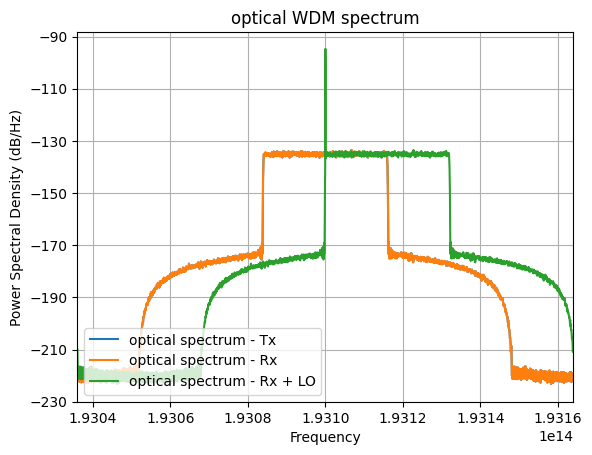

In [34]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# plots optical spectrum before and after transmission

# before
plt.figure()
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
)

# after
plt.psd(
    sigCh,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend(loc="lower left")
plt.title("optical spectrum")

# receiver detection and demodulation

Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# plot spectrum fter adding LO
plt.psd(
    sigRx,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

### Phase-retrieval stage

SIR =  25.63  dB


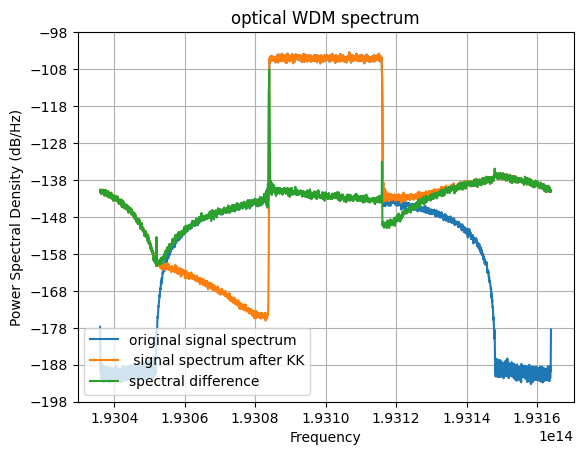

In [35]:
# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

# simulate ideal direct-detection optical receiver
Amp = np.abs(sigRx)
Amp = resample(Amp, paramADC)

# Kramers-Kronig phase-retrieval
phiTime = KramersKronigRx(Amp, newFs)

# optical field reconstruction
sigRx = Amp*np.exp(1j*phiTime)
sfm_KK = sigRx.copy()

# remove DC level
sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after KK",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

# calculate interference
intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR),2), ' dB')

#### Standard receiver processing

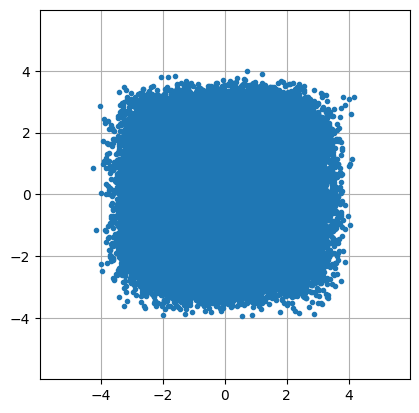

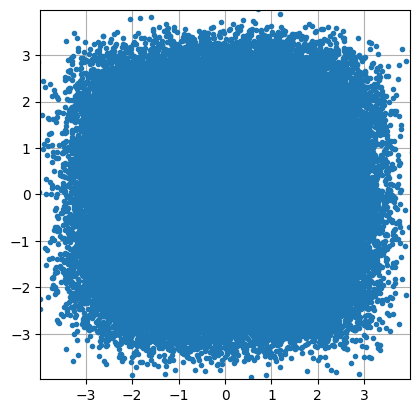

In [36]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)



nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022906.
nlms pre-convergence training iteration #1
nlms MSE = 0.002895.
nlms pre-convergence training iteration #2
nlms MSE = 0.002476.
nlms pre-convergence training iteration #3
nlms MSE = 0.002231.
nlms pre-convergence training iteration #4
nlms MSE = 0.002066.


dd-lms - training stage #1
dd-lms MSE = 0.001534.


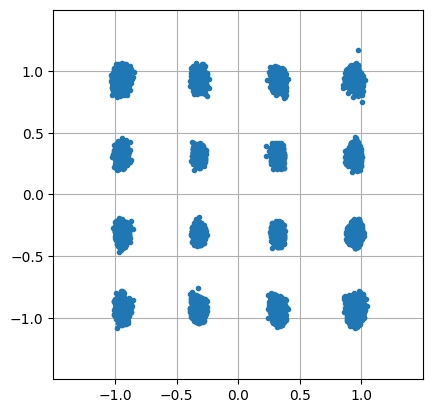

In [37]:
# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard, :], lim=True)

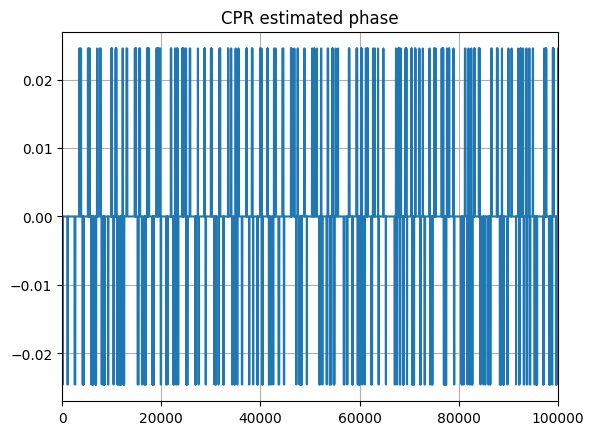

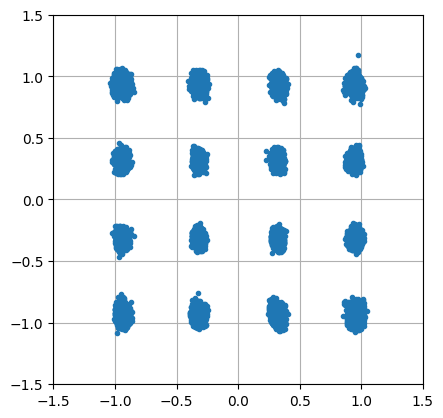

In [38]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 75
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)

#### Evaluate transmission metrics

In [39]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
MI = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]))

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 28.15 dB
MI: 4.00 bits
GMI: 4.00 bits


### Neural network training 

In [40]:
N = 256 # number of input amplitude samples to the NN

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(np.abs(sfm), (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_train = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_train[indPhase] = sigAmp[indPhase:N+indPhase]

# create set of phase labels
y_train = np.array([sfm.real, sfm.imag]).T

# define neural network model
#stop = EarlyStopping(monitor='val_loss', patience=5)
#model = create_convnet(N)
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
#model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)
#model.summary()

#model.save('ConvNets_models/convnet_model_SpS_'+str(paramTx.SpS), save_format='h5')

In [14]:
model = tf.keras.models.load_model(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\jupyter notebooks\ConvNets_models\convnet_model_SpS_4')
sfm_NN = model.predict(X_train)

C:\Users\Silas\AppData\Local\Temp\ipykernel_4120\2632733575.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-x" (-> color='k'). The keyword argument will take precedence.
  plt.plot(np.real(sfm)[300:400],'k-x',color='black', label='True - Real')


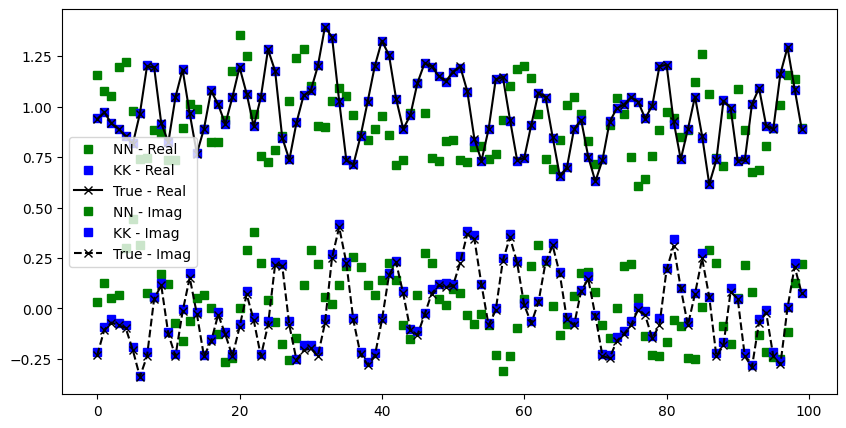

In [42]:
sfm_KK = sfm_KK/np.sqrt(signal_power(sfm_KK))

plt.figure(figsize=(10,5))
plt.plot(sfm_NN[300:400,0],'s',color='g',label='NN - Real')
plt.plot(np.real(sfm_KK)[300:400],'s',color='b',label='KK - Real')
plt.plot(np.real(sfm)[300:400],'k-x',color='black', label='True - Real')

plt.plot(sfm_NN[300:400,1],'s',color='g',label='NN - Imag')
plt.plot(np.imag(sfm_KK)[300:400],'s',color='b',label='KK - Imag')
plt.plot(np.imag(sfm)[300:400],'k--x',label='True - Imag')

plt.legend();

In [ ]:
#model = tf.keras.models.load_model('ConvNets_models/convnet_model_SpS_'+str(paramTx.SpS))